## CNN - Cats & Dogs Classifier with Keras

There is a "Dogs vs Cats" competition that was hold on Kaggle in the end of 2013 (https://www.kaggle.com/c/dogs-vs-cats)

The dataset contained 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition.

According to the Kaggle web-site, when this competition was launched (end of 2013): "State of the art: The current literature suggests machine classifiers can score above 80% accuracy on this task". Best models submitted for the competition reached 98.9% accuracy. 
The model in this playbook reaches 92.1% accuracy after 100 epochs so there is room for improvement!  

An open "playground" on the same subject is also available: https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition 

## Configuration

Download the dataset from https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data and unzip it into a dataset subdirectory.

Google a few cats & dogs pictures and put it into the PREDICT_DATA_DIR to play with the model

In [39]:
# Dataset locations
TRAINING_DATA_DIR = './dataset/training_set/'
TEST_DATA_DIR     = './dataset/test_set/'
PREDICT_DATA_DIR  = './dataset/single_prediction/'

In [40]:
# A random image taken on the internet
PREDICT_IMAGE = PREDICT_DATA_DIR + "cat_or_dog_1.jpg"

In [ ]:
# The file where the model will be saved
MODEL_FILE = './dataset/model.h5'

In [17]:
# Image dimensions
img_width,img_height = 150,150 

## Libraries

In [ ]:
import os.path
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt

## Model Definition

Creates a CNN model with 4 convolution+pooling layers and 3 dense layers
*    **p**: Dropout rate
*    **input_shape**: Shape of input 
*    **checkpoint_file**: name of checkpoint file (weights will be loaded to initialise the network with the result of a previous training)

In [19]:
def create_model(p, input_shape=(128,128,3),checkpoint_file='model.h5'):
    # CNN Initialisation
    model = Sequential()
    # First convolution & pooling Layer 
    model.add(Conv2D(32,(3,3),padding='same', input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Second convolution & pooling Layer 
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Third convolution & pooling Layer 
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Fourth convolution & pooling Layer 
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flattening
    model.add(Flatten())
    
    # Add 3 fully connected layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(p))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(p/2))
    model.add(Dense(1, activation='sigmoid'))
    
    # Load a trained network if any
    if os.path.isfile(checkpoint_file) :
        print("Restoring weights from %s" % checkpoint_file)
        model.load_weights(checkpoint_file)
    
    # Compiling the CNN
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [26]:
model = create_model(p=0.6,input_shape=(img_width,img_height,3),checkpoint_file=MODEL_FILE)  

Restoring weights from dataset/model.h5


## Train a model

### Create a training function

The **run_training** function has the following parameters:
*   **model**: the model to train
*   **bs**: batch size
*   **epochs**: number of epochs 
*   **checkpoint_file**: name of checkpoint to save the training progression

In [20]:
def run_training(model, bs=32, epochs=10, checkpoint_file='model.h5'):
    
    train_datagen = image.ImageDataGenerator(rescale = 1./255, 
                                       shear_range = 0.2, 
                                       zoom_range = 0.2, 
                                       horizontal_flip = True)
    test_datagen = image.ImageDataGenerator(rescale = 1./255)
 
    training_set = train_datagen.flow_from_directory(TRAINING_DATA_DIR,
                                                 target_size = (img_width,img_height),
                                                 batch_size = bs,
                                                 class_mode = 'binary')
                                                 
    test_set = test_datagen.flow_from_directory(TEST_DATA_DIR,
                                            target_size = (img_width,img_height),
                                            batch_size = bs,
                                            class_mode = 'binary')
    
    # Ask keras to save weights at the end of every epoch if a progress has been made
    checkpoint = ModelCheckpoint(checkpoint_file, 
                                 monitor='val_acc', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='max')
    
    # resume training                           
    model.fit_generator(training_set,
                        steps_per_epoch=8000/bs,
                        epochs = epochs,
                        validation_data = test_set,
                        validation_steps = 2000/bs,
                        callbacks=[checkpoint])


### Do the training
Run the training with a batch size of 32 images and 50 epochs

In [9]:
run_training(model,bs=32, epochs=50, checkpoint_file=MODEL_FILE)

## Validation

### Create an evaluation function

**Note:** Evaluation is made as part of the training so stats are available while you train but it is useful to have a standalone version

In [31]:
def run_evaluation(model,bs=32):
    test_datagen = image.ImageDataGenerator(rescale = 1./255)
    test_set = test_datagen.flow_from_directory(TEST_DATA_DIR,
                                            target_size = (img_width,img_height),
                                            batch_size = bs,
                                            class_mode = 'binary')
    return model.evaluate_generator(test_set)

### Run it & display the metrics

In [32]:
ev=run_evaluation(model)

Found 1736 images belonging to 2 classes.
[0.32321259283250375, 0.8778801843317973]


In [38]:
# print the result of the evaluation
for i in range(0,len(ev)):
    print('%s : %.5f' % (model.metrics_names[i],ev[i]))

loss : 0.32321
acc : 0.87788


## Prediction

### Create a prediction function

In [43]:
def run_model(model,file):
    test_image = image.load_img(file,target_size = (img_width, img_height))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = model.predict(test_image)
    return result[0][0]

### The image to predict

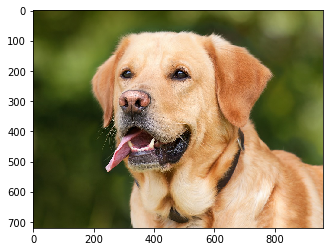

In [21]:
img = plt.imread(PREDICT_IMAGE)
plt.imshow(img)

### Do the prediction

In [44]:
categories = ["cat","dog"]
res = run_model(model,PREDICT_IMAGE)
print('This is a %s' % categories[int(res)])

This is a dog
